In [341]:
# import pandas as pd

# df = pd.read_csv("magnetism_split.csv")
# df

In [342]:
# float64_cols = list(df.select_dtypes(include='float64'))
# df[float64_cols] = df[float64_cols].astype('float32')

In [343]:
# df.iloc[:,3].values.dtype

In [344]:
# import pandas as pd
# from darts import TimeSeries

# # Assuming 'your_dataset.csv' is a string containing the dataset

# # df = pd.read_csv(pd.compat.StringIO('your_dataset.csv'))

# # Convert the 'Timestamp' column to datetime type
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# time_series_list = []
# for ccr_id, group in df.groupby('Subsection'):
#     # Sort the group by 'Timestamp' if not already sorted
#     group.sort_values('Timestamp', inplace=True)
    
#     # Set the 'Timestamp' column as the index
#     group.set_index('Timestamp', inplace=True)
    
#     # Exclude the 'CCR_ID' column from numeric conversion and resampling
#     value_cols = ['Elapsed time (minutes)', 'Set B field (T)', 'B field (T)', 'Ramp speed (T/min)', 'Voltage (V)', 'Inner Lower Temperature', 'Outer Lower Temperature', 'Inner Upper Temperature', 'Outer Upper Temperature', '1st Stage Temperature', 'Shield Temperature', '2nd Stage Temperature', ]
#     # value_cols = ['Elapsed time (minutes)','Setpoint (K)','Sensor A (K)','Sensor B (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)', 'Slope','Intercept','Sensor C (K) or sensor A (sensor unit)','Sensor D (K) or sensor B (sensor unit)']
    
#     # Convert the numeric columns to numeric format, handling non-numeric values as NaN
#     for col in value_cols:
#         group[col] = pd.to_numeric(group[col], errors='coerce')
    
#     # Select only numeric columns for resampling
#     numeric_cols = group.select_dtypes(include='number').columns
    
#     # Resample the numeric columns to a fixed frequency
#     group_resampled = group[numeric_cols].resample('1T').mean()  # Adjust '5S' to the desired frequency
    
#     # Handle missing values if necessary
#     group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropriate method
    
#     # Convert the resampled DataFrame to a Darts TimeSeries object
#     time_series = TimeSeries.from_dataframe(group_resampled, value_cols=value_cols)
    
#     time_series_list.append(time_series)


In [345]:
# len(time_series_list[0])

In [346]:
import pickle

In [347]:
# with open('timeseries_split_1T','wb') as f: pickle.dump(time_series_list, f)

In [348]:
cd split

[Errno 2] No such file or directory: 'split'
/storage/rwp2/Pipeline/Dask/filtered


In [349]:
with open('timeseries_4000_filtered','rb') as f: time_series_loaded = pickle.load(f)

In [350]:
# print(time_series_loaded == time_series_list)

In [351]:
# print(len(time_series_list[0]))

In [352]:
time_series_list = time_series_loaded

In [353]:
print(len(time_series_list))

66


In [354]:
# fix python path if working locally
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
    RandomForest
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [355]:
time_series_list_scaled = []

for time_series in time_series_list:
    scaler = Scaler()
    time_series_list_scaled.append(scaler.fit_transform(time_series))

In [356]:
# print(time_series_list_scaled[0].columns)
from darts import TimeSeries
temp = []
# Assuming you have a Darts TimeSeries object named 'ts'

# Convert the TimeSeries to a pandas DataFrame
for ts in time_series_list_scaled:
    df = ts.pd_dataframe()

    # Rename the columns in the pandas DataFrame
    new_column_names = ['Normalized Elapsed time (minutes)', 'Normalized Set B field (T)', 'Normalized B field (T)',
       'Normalized Ramp speed (T/min)', 'Normalized Voltage (V)', 'Normalized Inner Lower Temperature',
       'Normalized Outer Lower Temperature', 'Normalized Inner Upper Temperature',
       'Normalized Outer Upper Temperature', 'Normalized 1st Stage Temperature',
       'Normalized Shield Temperature', 'Normalized 2nd Stage Temperature']  # Replace with the new column names you want
    df.columns = new_column_names

    # Convert the modified pandas DataFrame back to a Darts TimeSeries
    temp.append(TimeSeries.from_dataframe(df))
time_series_list_scaled = temp
print(time_series_list_scaled[0].columns)

Index(['Normalized Elapsed time (minutes)', 'Normalized Set B field (T)',
       'Normalized B field (T)', 'Normalized Ramp speed (T/min)',
       'Normalized Voltage (V)', 'Normalized Inner Lower Temperature',
       'Normalized Outer Lower Temperature',
       'Normalized Inner Upper Temperature',
       'Normalized Outer Upper Temperature',
       'Normalized 1st Stage Temperature', 'Normalized Shield Temperature',
       'Normalized 2nd Stage Temperature'],
      dtype='object', name='component')


In [357]:
from darts import TimeSeries

covariates = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['Set B field (T)']
    covariate_ts_df = ts_df[columns_to_keep]
    covariates.append(TimeSeries.from_dataframe(covariate_ts_df))


In [358]:
updated_covariates = []
for i in range(len(covariates)):
    df = covariates[i].pd_dataframe()
    # for time_series in time_series_list_scaled:
    temp = time_series_list_scaled[i].pd_dataframe()
    for col in temp.columns:
        df[col] = temp[col]
    updated_covariates.append(TimeSeries.from_dataframe(df))
    
print(updated_covariates[0].columns)
# covariates = updated_covariates


Index(['Set B field (T)', 'Normalized Elapsed time (minutes)',
       'Normalized Set B field (T)', 'Normalized B field (T)',
       'Normalized Ramp speed (T/min)', 'Normalized Voltage (V)',
       'Normalized Inner Lower Temperature',
       'Normalized Outer Lower Temperature',
       'Normalized Inner Upper Temperature',
       'Normalized Outer Upper Temperature',
       'Normalized 1st Stage Temperature', 'Normalized Shield Temperature',
       'Normalized 2nd Stage Temperature'],
      dtype='object', name='component')


In [359]:
temp1 = []
from darts import concatenate
for col in temp.columns:
    temp1.append(TimeSeries.from_series(df[col]))
print(type(temp1[0]))
covariates = concatenate([timeSeries for timeSeries in temp1], axis=1)

<class 'darts.timeseries.TimeSeries'>


In [361]:
print(covariates)

<TimeSeries (DataArray) (Timestamp: 4000, component: 12, sample: 1)>
array([[[0.0000000e+00],
        [9.8434258e-01],
        [9.9528265e-01],
        ...,
        [8.9167404e-01],
        [9.3036294e-01],
        [9.2775822e-01]],

       [[2.4580956e-04],
        [9.8434258e-01],
        [9.9527884e-01],
        ...,
        [8.9167404e-01],
        [9.3036294e-01],
        [9.2775822e-01]],

       [[4.9304962e-04],
        [9.8434258e-01],
        [9.9527574e-01],
        ...,
...
        ...,
        [1.3496399e-02],
        [1.2595367e-01],
        [5.0635576e-02]],

       [[9.9974871e-01],
        [8.6022019e-03],
        [8.4785223e-03],
        ...,
        [1.2493134e-02],
        [1.2599111e-01],
        [5.4628372e-02]],

       [[1.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [1.1442184e-02],
        [1.2604594e-01],
        [5.8809996e-02]]], dtype=float32)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2019-02-14T04:47:00

In [323]:
from darts import TimeSeries

# ts_df = ts.pd_dataframe()
time_final = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['B field (T)', 'Voltage (V)', 'Ramp speed (T/min)', 'Inner Lower Temperature', 
            'Outer Lower Temperature', 'Inner Upper Temperature',
            'Outer Upper Temperature', '1st Stage Temperature',
            'Shield Temperature', '2nd Stage Temperature']
    covariate_ts_df = ts_df[columns_to_keep]
    time_final.append(TimeSeries.from_dataframe(covariate_ts_df))
    
print(len(time_final[0].columns ))
# time_final = time_series_list

10


In [324]:
print(len(time_final))

66


In [325]:
print(len(covariates))

4000


In [335]:
# load data
train, val = [], []
# VAL_LEN = 300
covariates_temp, val_covariates = [], []

# for i in range(len(time_final)):
#     series = time_final[i]
#     train.append(series[:-VAL_LEN])
#     val.append(series[-VAL_LEN:])
#     temp1.append(covariates[i][-VAL_LEN:])
#     temp2.append(covariates[i][:-VAL_LEN])
    
for i in range(len(time_final)):
    series = time_final[i]
    # train.append(series)
    # val.append(series[-VAL_LEN:])
    train.append(series[:-VAL_LEN])
    val.append(series[-VAL_LEN:])
    # temp1.append(covariates[i])
for i in range(len(covariates)):
    covariates_temp.append(covariates[i][:-VAL_LEN])
    val_covariates.append(covariates[i][-VAL_LEN:])

# for time_series in time_final:
#     series = time_series.astype(np.float32)
#     train.append(series[:-VAL_LEN])
#     val.append(series[-VAL_LEN:])
# ValueError: The dimensions of the series in the training set and the validation set do not match.
    
    
# for time_series in covariates:
#     series = time_series.astype(np.float32)
#     temp.append(series[:-VAL_LEN])
# # val_past_covariates_past = temp1
# covariates = temp2

# # val = train[60:][:-(VAL_LEN+300)]
# train = train[:60]
covariates = covariates_temp
# # val_covariates = covariates[60:][-(VAL_LEN+300):]
# covariates = covariates[:60]
# # split in train / validation (note: in practice we would also need a test set)
# train, val = 


In [340]:
print(len(covariates[0]))
print(len(train[0]))

0
3700


In [336]:
# train = train[:20]
# val = val[:20]
# covariates = covariates[:2]
# val_past_covariates_past = val_past_covariates_past[:2]

In [337]:
# class Trial():
#     def suggest_int(self, name, low, high):
#         return low
#     def suggest_categorical(self, name, cats):
#         return cats[0]
#     def suggest_float(self, name, low, high, log = False):
#         return low
        

In [339]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

# scale
# scaler = Scaler(MaxAbsScaler())
# train = scaler.fit_transform(train)
# val = scaler.transform(val)

# define objective function


pl_trainer_kwargs = {
    "accelerator": "gpu",
    "devices": [0],
    # "callbacks": callbacks,
}

encoders = None #look into add encoders

# reproducibility
torch.manual_seed(42)

model = TransformerModel(
    input_chunk_length=52,
    output_chunk_length=33,
    batch_size=64,
    n_epochs=1,
    # nr_epochs_val_period=1,
    # num_encoder_layers = num_encoder_layers_temp,
    # num_decoder_layers = num_decoder_layers_temp,
    # d_model = d_model_length,
    # dropout=dropout,
    # optimizer_kwargs={"lr": lr},
    # add_encoders=encoders,
    # likelihood=GaussianLikelihood(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="tcn_model_2",
    force_reset=True,
    save_checkpoints=True,
)

# train the model
model.fit(
    series=train,
    val_series=val,
    # num_loader_workers=1,
    past_covariates = covariates,
    val_past_covariates=val_covariates
)


ValueError: The provided sequence of target series must have the same length as the provided sequence of covariate series.

In [299]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

# scale
# scaler = Scaler(MaxAbsScaler())
# train = scaler.fit_transform(train)
# val = scaler.transform(val)

# define objective function
def objective(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_int("in_len", 80, 180)
    out_len = trial.suggest_int("out_len", 40, in_len-1)
    # d_model_length = trial.suggest_int("d_model_length", 60, 68)
    num_encoder_layers_temp = trial.suggest_int("num_encoder_layers_temp", 2, 5)
    num_decoder_layers_temp = trial.suggest_int("num_decoder_layers_temp", 3, 7)
    # dim_feedforward_temp = trial.suggest_int("dim_feedforward_temp", 512, 2048)
    activation_temp =  trial.suggest_categorical("activation_temp", ["ReGLU", "GEGLU", "SwiGLU", "ReLU", "GELU"])
    # activation = activation_temp,
    
    kernel_size = trial.suggest_int("kernel_size", 4, 7)
    num_filters = trial.suggest_int("num_filters", 2, 4)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 3, 6)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 5e-6, 1e-3, log=True)
    # include_year = trial.suggest_categorical("year", [False, True])

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [pruner, early_stopper]
    
    num_workers = 4
        
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        # "callbacks": callbacks,
    }

    encoders = None #look into add encoders

    # reproducibility
    torch.manual_seed(42)
    # kernel_size', 'num_filters', 'weight_norm', 'dilation_base']`
    # build the TCN model
    model = TransformerModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=128,
        n_epochs=1,
        nr_epochs_val_period=1,
        num_encoder_layers = num_encoder_layers_temp,
        num_decoder_layers = num_decoder_layers_temp,
        # d_model = d_model_length,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=GaussianLikelihood(),
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tcn_model_3",
        force_reset=True,
        save_checkpoints=True,
    )
    
    # train the model
    # VAL_LEN = 300
    model.fit(
        series=train,
        val_series=val,
        # num_loader_workers=1,
        past_covariates = covariates,
        val_past_covariates=val_covariates
    )
    
#     model.fit(
#         series=train,
#         past_covariates=covariates,
#     );

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint("tcn_model_3")
    
    # Evaluate how good it is on the validation set, using sMAPE
    # preds = model.predict(series=train[0], n=VAL_LEN)
    VAL_LEN = 1000
    smapes = 0
    for i in range(len(val)):
        preds = model.predict(
            series=train[i][:3000],
            # val_future_covariates = covariates[60 + i]
            past_covariates = covariates[i][:3000],
            n=VAL_LEN,
            # verbose=verbose,
        )
        smapes += smape(preds, train[i][3000:])
    smapes = smapes/len(train)
    smape_val = np.mean(smapes)
    # if smape_val== np.nan:
    #     print("nan")
    return smape_val if smape_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the sMAPE on the validation set
def run_trial():
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=3, callbacks=[print_callback])
        
if __name__ == "__main__":
    run_trial()
    # objective(Trial())


ValueError: Missing covariates; could not find past covariates in index value range: 2019-02-22 03:42:00 - 2019-02-22 05:50:00.

In [30]:
# fix python path if working locally
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [25]:
cd filtered

/storage/rwp2/Pipeline/Dask/filtered


In [29]:
num = 0

In [36]:
print(len(train[1]))

3700


In [37]:
# temp = train[1][:7000+VAL_LEN]

In [69]:
cd split

/storage/rwp2/Pipeline/Dask/split


In [27]:
loaded_model = TransformerModel.load_from_checkpoint('transformer-3357/T0314')

In [115]:
loaded_model = TransformerModel.load_from_checkpoint('tcn_model_3')

In [116]:
import pandas as pd
from darts import TimeSeries

# Assuming 'your_dataset.csv' is a string containing the dataset

df = pd.read_csv('whole.csv')

# Convert the 'Timestamp' column to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
float64_cols = list(df.select_dtypes(include='float64'))
df[float64_cols] = df[float64_cols].astype('float32')
time_series_list = []
for ccr_id, group in df.groupby('Magnetism_ID'):
    # Sort the group by 'Timestamp' if not already sorted
    group.sort_values('Timestamp', inplace=True)
    
    # Set the 'Timestamp' column as the index
    group.set_index('Timestamp', inplace=True)
    
    # Exclude the 'CCR_ID' column from numeric conversion and resampling
    value_cols = ['Elapsed time (minutes)', 'Set B field (T)', 'B field (T)', 'Ramp speed (T/min)', 'Voltage (V)', 'Inner Lower Temperature', 'Outer Lower Temperature', 'Inner Upper Temperature', 'Outer Upper Temperature', '1st Stage Temperature', 'Shield Temperature', '2nd Stage Temperature', ]
    # value_cols = ['Elapsed time (minutes)','Setpoint (K)','Sensor A (K)','Sensor B (K)', 'Heater Output % (0-100)', 'Heater Range (integer 0-5)', 'Slope','Intercept','Sensor C (K) or sensor A (sensor unit)','Sensor D (K) or sensor B (sensor unit)']
    
    # Convert the numeric columns to numeric format, handling non-numeric values as NaN
    for col in value_cols:
        group[col] = pd.to_numeric(group[col], errors='coerce')
    
    # Select only numeric columns for resampling
    numeric_cols = group.select_dtypes(include='number').columns
    
    # Resample the numeric columns to a fixed frequency
    group_resampled = group[numeric_cols].resample('1T').mean()  # Adjust '5S' to the desired frequency
    
    # Handle missing values if necessary
    group_resampled = group_resampled.fillna(method='ffill')  # Forward fill missing values, or choose another appropriate method
    
    # Convert the resampled DataFrame to a Darts TimeSeries object
    time_series = TimeSeries.from_dataframe(group_resampled, value_cols=value_cols)
    
    time_series_list.append(time_series)


In [44]:
from darts import TimeSeries

# ts_df = ts.pd_dataframe()
time_temp = []
for i in range(len(time_series_list)):
    ts_df = (time_series_list[i]).pd_dataframe()
    columns_to_keep = ['B field (T)', 'Voltage (V)', 'Ramp speed (T/min)', 'Inner Lower Temperature', 
            'Outer Lower Temperature', 'Inner Upper Temperature',
            'Outer Upper Temperature', '1st Stage Temperature',
            'Shield Temperature', '2nd Stage Temperature']
    covariate_ts_df = ts_df[columns_to_keep]
    time_temp.append(TimeSeries.from_dataframe(covariate_ts_df))
    
print(len(time_final[0].columns ))
# time_final = time_series_list

10


In [126]:
num = 0
n_forecast = len(val[num])  # Replace `test` with your test set
n_forecast = 500
pred_series = loaded_model.predict(n=n_forecast, series=train[60][:2000], past_covariates = covariates[60][:7000])  # Adjust the `n` parameter as needed

Predicting: 0it [00:00, ?it/s]

In [127]:
# n_forecast = len(temp)  # Replace `test` with your test set
# pred_series = loaded_model.predict(n=n_forecast, series=train[num][:300])  # Adjust the `n` parameter as needed

In [128]:
from darts.metrics import mape, rmse

smape_score = smape(pred_series, train[num][300:600])  # Replace `test` with your true future values
rmse_score = rmse(pred_series, train[num][300:600])  # Replace `test` with your true future values

print(f"SMAPE: {smape_score:.2f}%")
print(f"RMSE: {rmse_score:.2f}")

SMAPE: nan%
RMSE: nan


In [129]:
print(np.mean(smape_score))

nan


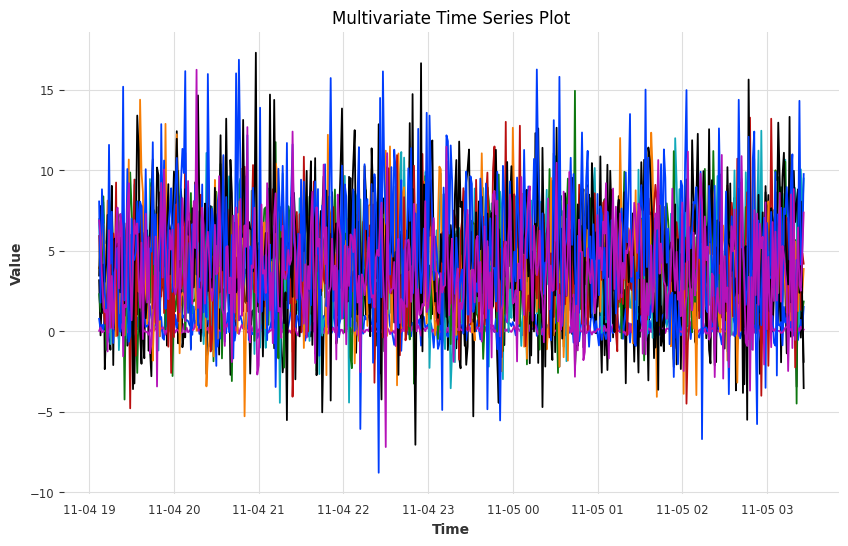

In [130]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (pred_series).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
# plt.legend()
plt.grid(True)
plt.show()


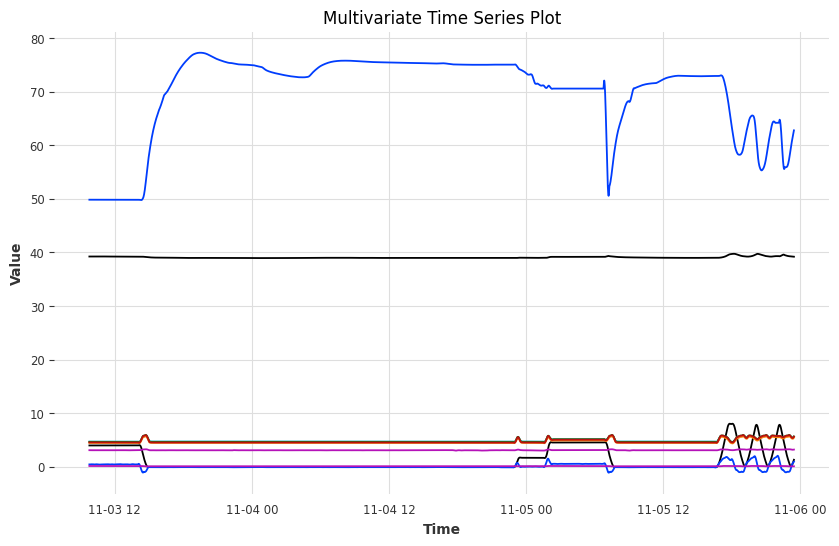

In [122]:
import matplotlib.pyplot as plt
from darts import TimeSeries

# Assuming you have a multivariate Darts time series named 'multivariate_time_series'

# Convert the Darts time series to a Pandas DataFrame
df = (train[60][:4000]).pd_dataframe()
# df = (val[num]).pd_dataframe()

# Plotting the multivariate time series
plt.figure(figsize=(10, 6))

# Plot each variable separately
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multivariate Time Series Plot')
# plt.legend()
plt.grid(True)
plt.show()


In [ ]:
I 2023-07-31 16:21:07,924] Trial 92 finished with value: 
    140.74493944644928 and parameters: {'d_model_length': 67, 'dilation_base': 4, 
                                        'dropout': 0.05325962047210396, 'in_len': 69, 'kernel_size': 5, 
                                        'lr': 0.00035671372383447384, 'num_decoder_layers_temp': 3, 'num_encoder_layers_temp': 5, 
                                        'num_filters': 3, 'out_len': 31, 'weight_norm': False}. Best is trial 92 with value: 140.74493944644928.

In [64]:
pickled_model = pickle.load(open("regression_1.pkl",'rb'))


In [66]:
pickled_model.predict(train[num])

ValueError: Input series has to be provided after fitting on multiple series.